# Tutorial 1: Basics of CrypTen Tensors

We now have a high-level understanding of how secure MPC works. Through these tutorials, we will explain how to use CrypTen to carry out secure operations on encrypted tensors. In this tutorial, we will introduce a fundamental building block in CrypTen, called a ```CrypTensor```.  ```CrypTensors``` are encrypted ```torch``` tensors that can be used for computing securely on data. 

CrypTen currently only supports secure MPC protocols (though we intend to add support for other advanced encryption protocols). Using the ```mpc``` backend, ```CrypTensors``` act as ```torch``` tensors whose values are encrypted using secure MPC protocols. Tensors created using the ```mpc``` backend are called ```MPCTensors```. We will go into greater detail about ```MPCTensors``` in Tutorial 2. 

Let's begin by importing ```crypten``` and ```torch``` libraries. (If the imports fail, please see the installation instructions in the README.)

In [1]:
import crypten
import torch
from crypten.config import cfg
import timeit
import crypten.communicator as comm
import logging
import matplotlib.pyplot as plt
import numpy as np

crypten.init()
# logging.getLogger().setLevel(logging.INFO)

# torch.set_num_threads(1)

# comm.get().set_verbosity(True)
# ... do stuff ..
# comm.get().print_communication_stats()

In [3]:
def print_diff(x, z_enc):
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    print(f"TAE: {diff.sum():e}, MAE: {diff.mean():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
    # print(diff[:print_terms])
    plt.plot(diff)
    
def print_diff_numb(x, z_enc):
    diff = torch.abs(x - z_enc.get_plain_text()).numpy()
    relative = torch.abs((z_enc.get_plain_text()-x)/x)
    relative = relative[relative != float("inf")].numpy()
    relative = relative[~np.isnan(relative)]
    print(f"TAE: {diff.sum():e}, MAE: {diff.mean():e}, MRE: {relative.mean():e}, MAX: {diff.max():e}, ARGMAX: {diff.argmax()}")
num_iters = 1
print_terms = 1

def print_app(name, end_time, start_time):
    print(f"  {name}: {num_iters} iterations in {end_time - start_time} sec.") # : {z_enc.get_plain_text()[:print_terms]}")


## Initial tests

In [3]:
import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_sum():
    x_enc = crypten.cryptensor(torch.arange(5, 15, 1))   
    # m = torch.arange(3, 10, 1)   
    crypten.print("\nx is:", x_enc.get_plain_text())
    y_enc = x_enc.mod(4)
    crypten.print("\ny is:", y_enc.get_plain_text())

test_sum()


x is: tensor([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.])

y is: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


[None, None]

## Negative exp (Checked - Crypten)

Conclusion:
- If we do not consider the interval [-1, 0] the bior gets really close to exp (almost the same)
- CrypTen's approximation is always better.
- Split is better with one party (no error) but gets worse with two parties.

torch.Size([64000])
Negative Exponential:
  Approx: 1 iterations in 0.022330458014039323 sec.
TAE: 7.149363e-05, MRE: 8.482303e-01, MAX: 3.611863e-03
  Bior: 1 iterations in 0.03994020802201703 sec.
TAE: 3.848229e-05, MRE: 8.755276e-01, MAX: 4.234135e-03


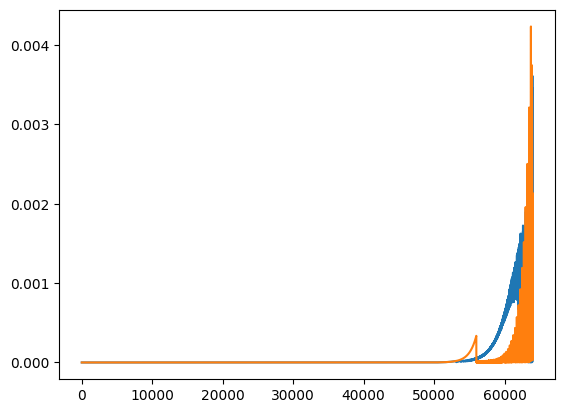

In [3]:
#Construct example input CrypTensor
x = torch.arange(-64, 0, 0.001)
# x = x.reshape([1600, 10])
print(x.size())
# x = torch.tensor([0.01, 0.5])
x_enc = crypten.cryptensor(x)

print("Negative Exponential:")
# print("  Exact :", x.exp()[:print_terms])
with cfg.temp_override({"functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
# with cfg.temp_override({"functions.exp_method": 'split', "functions.exp_all_neg": True}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.exp()  # Private
#     # print("  Nexp   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Nexp", timeit.default_timer(), start1)
#     print_diff(x.exp(), z_enc)
# with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": True}):
#     start1 = timeit.default_timer()
#     for _ in range(num_iters):
#         z_enc = x_enc.exp()  # Private
#     # print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
#     print_app("Haar", timeit.default_timer(), start1)
#     print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": True}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    # print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(x.exp(), z_enc)

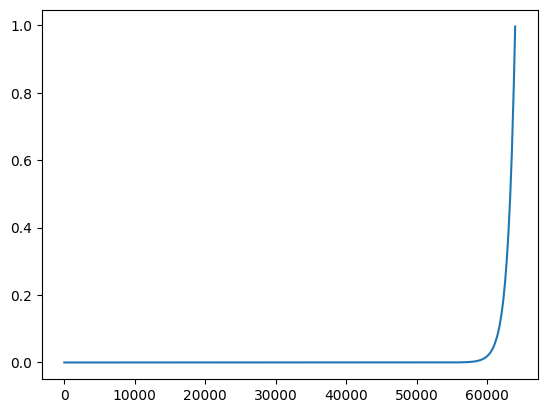

In [4]:
plt.plot(z_enc.get_plain_text())

In [3]:
#Construct example input CrypTensor
x = torch.arange(-8, 8, 0.3)
print(x.size())
# x = torch.tensor([0.01, 0.5])
x_enc = crypten.cryptensor(x)

print("Exponential:")
print("  Exact :", x.exp()[:print_terms])
with cfg.temp_override({"functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": False}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)
with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": False}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.exp()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.exp(), z_enc)

torch.Size([54])
Exponential:
  Exact : tensor([0.0003])
  Approx: 1 iterations in 0.010859876998438267 sec.: tensor([0.0003])
TAE: 9.896224e+02, MRE: 4.457789e-02, MAX: 3.100916e+02
  Haar  : 1 iterations in 0.0106402130004426 sec.: tensor([1.0158])
TAE: 1.361802e+07, MRE: 5.348339e+05, MAX: 6.203709e+06
  Bior  : 1 iterations in 0.007976648999829195 sec.: tensor([0.0071])
TAE: 1.656615e+04, MRE: 8.443229e+02, MAX: 4.394732e+03


In [18]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_exp():
    #Construct example input CrypTensor
    # x = torch.arange(start=0.001, end=10, step=0.001)
    x = torch.arange(-63, 0, 0.1)
    print(x.size())
    # x = torch.tensor([0.01, 0.5])
    x_enc = crypten.cryptensor(x)

    print("Exponential:")
    print("  Exact :", x.exp()[:print_terms])
    with cfg.temp_override({"functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'split'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Split:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'haar', "functions.exp_all_neg": True}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)
    with cfg.temp_override({"functions.exp_method": 'bior', "functions.exp_all_neg": True}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.exp()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff(x.exp(), z_enc)

test_exp()

torch.Size([630])torch.Size([630])

Exponential:Exponential:

  Exact :  Exact :  tensor([4.3596e-28])tensor([4.3596e-28])

  Approx:  Approx:  11  iterations initerations in  0.03343685800064122 0.03978172599818208sec.:  sec.: tensor([0.])
tensor([0.])
TAE: 4.627337e-02, MAE: 7.344980e-05, MRE: 8.577805e-01, MAX: 2.015412e-03, ARGMAX: 624TAE: 4.627337e-02, MAE: 7.344980e-05, MRE: 8.577805e-01, MAX: 2.015412e-03, ARGMAX: 624

  Split:  Split: 1  1iterations in  iterations in0.33886613600043347  0.34699450799962506sec.:  sec.: tensor([0.8825])
tensor([0.8825])
TAE: 4.155312e+02, MAE: 6.595733e-01, MRE: 3.376391e+25, MAX: 8.824921e-01, ARGMAX: 1TAE: 4.155312e+02, MAE: 6.595733e-01, MRE: 3.376391e+25, MAX: 8.824921e-01, ARGMAX: 1

  Haar  :  Haar  :  1 1 iterations in iterations in0.22676783600036288  0.23490432600010536sec.: sec.:  tensor([0.1312])
tensor([0.1312])
TAE: 2.572593e+02, MAE: 4.083481e-01, MRE: 5.335945e+24, MAX: 8.833208e-01, ARGMAX: 594TAE: 2.572593e+02, MAE: 4.083481e-01,

[None, None]

## Reciprocal (checked)

Conclusion:
- Sometimes the errors get completelly off (e.g. reciprocal, if I run it several times the bior case 1 in 5 times explodes. If I decrease the set from [0, 64] to [0, 63], there is no issue then.
- Note: Haar is more stable but the same happens. When we have a bad bior, then Haar is better.


Reciprocal:
  Approx: 1 iterations in 0.08681222599989269 sec.
TAE: 1.650533e-01, MAE: 2.624058e-04, MRE: 1.117153e-02, MAX: 9.487513e-04, ARGMAX: 626
  Log: 1 iterations in 0.15935298099975626 sec.
TAE: 2.234099e-01, MAE: 3.551826e-04, MRE: 1.945818e-03, MAX: 2.494347e-02, ARGMAX: 2
  Haar: 1 iterations in 0.013412623999101925 sec.
TAE: 5.727524e-01, MAE: 9.105762e-04, MRE: 4.210693e-03, MAX: 5.922955e-02, ARGMAX: 1
  Bior: 1 iterations in 0.02218342699961795 sec.
TAE: 1.971410e-02, MAE: 3.134197e-05, MRE: 3.015338e-04, MAX: 3.214538e-03, ARGMAX: 4


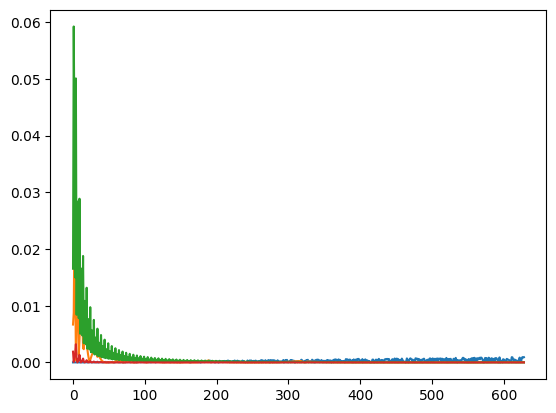

In [3]:
# x = torch.tensor([0.00005, 0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]) # , 5, 10, 50, 100 , 500, 1000, 5000, 10000, 50000])
x = torch.arange(start=1.1, end=64, step=0.1)
# x = torch.arange(start=1.01, end=10, step=0.01)
# x = x.reshape((63, 100))
x_enc = crypten.cryptensor(x)

print("\nReciprocal:")
# print("  Exact :", x.reciprocal()[:print_terms])
with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Log", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)
with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.reciprocal()  # Private
    # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(x.reciprocal(), z_enc)

In [21]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_rec():
    #Construct example input CrypTensor
    # x = torch.arange(start=0.001, end=10, step=0.001)
    # x = torch.tensor([0.00005, 0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]) # , 5, 10, 50, 100 , 500, 1000, 5000, 10000, 50000])
    # x = torch.arange(1.0, 64, 0.001)
    # x = torch.arange(start=1.01, end=10, step=0.01)
    x = torch.arange(start=1.01, end=64, step=0.01)
    x = torch.arange(start=1.0, end=63.9, step=0.1)
    # x = x.reshape((63, 100))
    x_enc = crypten.cryptensor(x)

    print("\nReciprocal:")
    # print("  Exact :", x.reciprocal()[:print_terms])
    with cfg.temp_override({"functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'log', "functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Log", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)
    with cfg.temp_override({"functions.reciprocal_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.reciprocal()  # Private
        # print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(x.reciprocal(), z_enc)

test_rec()


Reciprocal:
Reciprocal:

  Approx: 1 iterations in 0.11489249399892287 sec.  Approx: 1 iterations in 0.11536057999910554 sec.

TAE: 9.980349e-02, MAE: 1.586701e-04, MRE: 6.747133e-03, MAX: 7.948317e-04, ARGMAX: 589TAE: 9.980349e-02, MAE: 1.586701e-04, MRE: 6.747133e-03, MAX: 7.948317e-04, ARGMAX: 589

  Log: 1 iterations in 0.2211278710001352 sec.  Log: 1 iterations in 0.22154653699908522 sec.

TAE: 2.065105e+00, MAE: 3.283156e-03, MRE: 4.364233e-02, MAX: 1.337924e-01, ARGMAX: 64TAE: 2.065105e+00, MAE: 3.283156e-03, MRE: 4.364233e-02, MAX: 1.337924e-01, ARGMAX: 64

  Haar: 1 iterations in 0.12908103599875176 sec.
  Haar: 1 iterations in 0.15740455499872041 sec.
TAE: 1.354484e+00, MAE: 2.153393e-03, MRE: 8.951111e-03, MAX: 1.798123e-01, ARGMAX: 1TAE: 1.354484e+00, MAE: 2.153393e-03, MRE: 8.951111e-03, MAX: 1.798123e-01, ARGMAX: 1

  Bior: 1 iterations in 0.14755208700080402 sec.  Bior: 1 iterations in 0.1481703869994817 sec.

TAE: 1.167816e-01, MAE: 1.856623e-04, MRE: 4.779850e-04, MAX

[None, None]

## Logarithm (checked)

Conclusion:
- For torch.arange(0.1, 64, 0.1):
>- Bior has better accuracy
- For torch.arange(0.01, 64, 0.01):
>- Haar has better accuracy


Logarithm (LUT faster):
  Exact : tensor([-4.6052])
  Approx: 1 iterations in 0.16266293499984386 sec.: tensor([-9.5224])
TAE: 3.234917e+02, MAE: 5.055348e-02, MRE: 3.803601e-02, MAX: 6.207090e+00, ARGMAX: 8
  Haar  : 1 iterations in 0.0560089139999036 sec.: tensor([-2.3859])
TAE: 5.055320e+01, MAE: 7.900171e-03, MRE: 1.525556e-02, MAX: 2.219230e+00, ARGMAX: 0
  Bior  : 1 iterations in 0.07224627999994482 sec.: tensor([-7.7378])
TAE: 6.053240e+01, MAE: 9.459666e-03, MRE: 5.024706e-03, MAX: 3.623935e+00, ARGMAX: 2


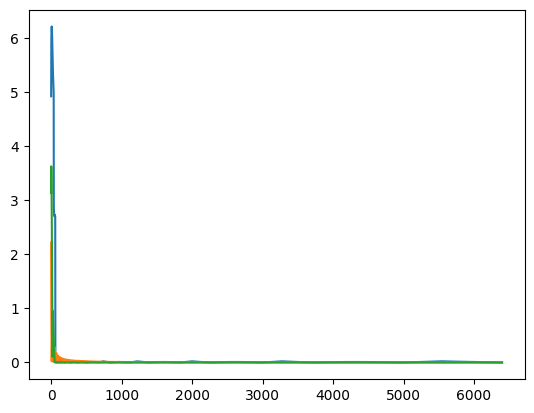

In [4]:
x = torch.arange(0.01, 64, 0.01)
x_enc = crypten.cryptensor(x)

print("\nLogarithm (LUT faster):")
print("  Exact :", x.log()[:print_terms])
with cfg.temp_override({"functions.log_method": 'iter'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)
with cfg.temp_override({"functions.log_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)
with cfg.temp_override({"functions.log_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.log()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.log(), z_enc)

In [6]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)
def test_log():
    rank = comm.get().get_rank()
    print("Rank is: ", rank)
    # x = torch.arange(5, 15, 1)
    x = torch.arange(0.01, 64, 0.01)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    # print("  x :", x) if rank == 0 else None
    # print("  Exact :", x.log()) if rank == 0 else None
    with cfg.temp_override({"functions.log_method": 'iter'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text()) 
        # if rank == 0:
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.log(), z_enc)
    with cfg.temp_override({"functions.log_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        # if rank == 0:
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.log(), z_enc)
    with cfg.temp_override({"functions.log_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.log()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        # if rank == 0:
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.log(), z_enc)

test_log()

Rank is: Rank is:   10


Logarithm (LUT faster):

Logarithm (LUT faster):


## Sqrt (checked)

Conclusions:
- Sqrt does not perform well for numbers in [0,1] when compared to CrypTen's approximaton
- CrypTen has huge error for square root with world size > 2
__________________________________________________________________________________________
LUT 7

x = torch.arange(start=0.1, end=64, step=0.1)

- World size 1:
  Exact : 
TAE: 8.912110e-01, MAE: 1.394696e-03, MRE: 3.674109e-04, MAX: 8.734703e-03, ARGMAX: 86
  Bior  
TAE: 4.200375e-01, MAE: 6.573357e-04, MRE: 1.302702e-03, MAX: 1.001023e-01, ARGMAX: 0

- World size 2: Huge error for square root with more elements
  Exact : 
TAE: 1.183356e+10, MAE: 1.851887e+07, MRE: 3.312523e+06, MAX: 3.880408e+09, ARGMAX: 311 
  Bior  
TAE: 1.688408e+01, MAE: 2.642265e-02, MRE: 4.870367e-03, MAX: 8.172091e+00, ARGMAX: 637


x = torch.arange(start=0.01, end=64, step=0.01)

- World size 1:
  Exact : 
TAE: 9.005793e+00, MAE: 1.407375e-03, MRE: 5.083816e-04, MAX: 3.884277e-02, ARGMAX: 0
  Bior   : 
TAE: 4.248310e+00, MAE: 6.639021e-04, MRE: 1.442265e-03, MAX: 1.046040e-01, ARGMAX: 13

- World size 2:
 Exact : 
TAE: 8.076945e+10, MAE: 1.262220e+07, MRE: 2.258828e+06, MAX: 2.930533e+09, ARGMAX: 3151
  Bior   :  
TAE: 2.274174e+02, MAE: 3.553953e-02, MRE: 6.462289e-03, MAX: 8.490364e+00, ARGMAX: 6354

__________________________________________________________________________________________
LUT 6

x = torch.arange(start=0.1, end=64, step=0.1)

- World size 1
  Exact : 
TAE: 8.867714e+00, MAE: 1.387749e-03, MRE: 3.624862e-04, MAX: 8.783340e-03, ARGMAX: 852
  Bior  : 
TAE: 1.153096e+01, MAE: 1.804533e-03, MRE: 2.602629e-03, MAX: 1.489317e-01, ARGMAX: 18
- World size 2:

  Exact : 
TAE: 7.545336e+09, MAE: 1.180804e+07, MRE: 2.115324e+06, MAX: 3.516581e+09, ARGMAX: 308
   Bior   :  
TAE: 4.279654e+01, MAE: 6.697424e-02, MRE: 1.203176e-02, MAX: 8.326508e+00, ARGMAX: 634

torch.Size([639])

Square Root: (LUT faster)
  Exact : tensor([0.3162])
  Approx: 1 iterations in 0.051520500000151515 sec.: tensor([0.3149])
TAE: 8.912110e-01, MAE: 1.394696e-03, MRE: 3.674109e-04, MAX: 8.734703e-03, ARGMAX: 86
  Haar   : 1 iterations in 0.007510802000069816 sec.: tensor([0.4714])
TAE: 9.919294e+00, MAE: 1.552315e-02, MRE: 6.528697e-03, MAX: 1.610505e-01, ARGMAX: 3
  Bior   : 1 iterations in 0.014459600000009232 sec.: tensor([0.2161])
TAE: 4.200375e-01, MAE: 6.573357e-04, MRE: 1.302702e-03, MAX: 1.001023e-01, ARGMAX: 0


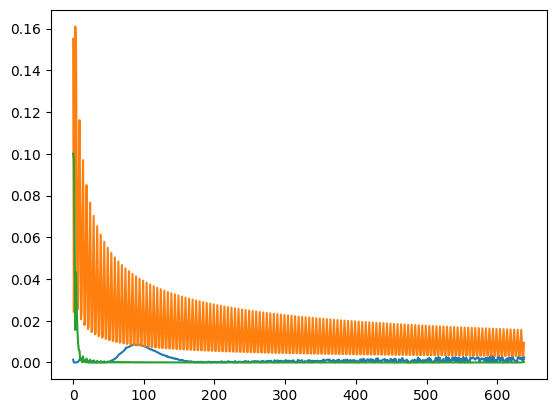

In [5]:
# x = torch.arange(1.0, 64, 0.01)
x = torch.arange(start=0.01, end=64, step=0.01)
x = torch.arange(start=0.1, end=64, step=0.1)
print(x.size())
x_enc = crypten.cryptensor(x)

print("\nSquare Root: (LUT faster)")
print("  Exact :", x.sqrt()[:print_terms])
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sqrt(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sqrt()  # Private
    print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt(), z_enc)

In [9]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)
def test_sqrt():
    # x = torch.arange(1.0, 64, 0.01)
    x = torch.arange(start=0.1, end=64, step=0.1)
    # x = torch.arange(start=0.1, end=64, step=0.1)
    print(x.size())
    x_enc = crypten.cryptensor(x)

    print("\nSquare Root: (LUT faster)")
    print("  Exact :", x.sqrt()[:print_terms])
    with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sqrt(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sqrt()  # Private
        print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt(), z_enc)

test_sqrt()

torch.Size([639])torch.Size([639])


Square Root: (LUT faster)
Square Root: (LUT faster)

  Exact :  Exact :  tensor([0.3162])tensor([0.3162])

  Approx:  Approx:  11  iterations initerations in  0.100092109998513480.10002528200129746  sec.:sec.:  tensor([0.3149])tensor([0.3149])

TAE: 7.545336e+09, MAE: 1.180804e+07, MRE: 2.115324e+06, MAX: 3.516581e+09, ARGMAX: 308TAE: 7.545336e+09, MAE: 1.180804e+07, MRE: 2.115324e+06, MAX: 3.516581e+09, ARGMAX: 308

  Haar   :  Haar   :  1 1iterations in  iterations in0.08848111699990113 0.13118774600116012  sec.:sec.:  tensor([0.6667])tensor([0.6667])

TAE: 7.703170e+01, MAE: 1.205504e-01, MRE: 3.240593e-02, MAX: 7.327076e+00, ARGMAX: 638TAE: 7.703170e+01, MAE: 1.205504e-01, MRE: 3.240593e-02, MAX: 7.327076e+00, ARGMAX: 638

  Bior   :  Bior   :  11 iterations in  iterations in0.21076177400027518  sec.: tensor([0.2099])0.2059802630010381
 sec.: tensor([0.2099])
TAE: 4.279654e+01, MAE: 6.697424e-02, MRE: 1.203176e-02, MAX: 8.326508e+00, ARGMAX: 634

[None, None]

## Inv sqrt (checked - Haar)

Conclusion:
- Haar always performs better when the [0,1] is included.
- Sqrt does not perform well for numbers in [0,1] when compared to CrypTen's approximation
- CrypTen explodes for world size 2

  Exact :  
TAE: 3.567988e+09, MAE: 5.583706e+06, MRE: 3.113768e+07, MAX: 1.547179e+09, ARGMAX: 308
  
  Haar   :  
TAE: 3.635196e+00, MAE: 5.688883e-03, MRE: 6.517332e-03, MAX: 8.149562e-01, ARGMAX: 0
  
  Bior   : 
TAE: 1.249464e+02, MAE: 1.955343e-01, MRE: 7.823918e-02, MAX: 7.181410e+01, ARGMAX: 0

torch.Size([639])

Inverse Square Root: (LUT faster)
  Exact : tensor([3.1623])
  Approx: 1 iterations in 0.061139634000937804 sec.: tensor([3.1494])
TAE: 8.538316e-02, MAE: 1.336200e-04, MRE: 3.667946e-04, MAX: 1.289415e-02, ARGMAX: 0
  Haar   : 1 iterations in 0.03153485999973782 sec.: tensor([3.3136])
TAE: 5.497249e-01, MAE: 8.602894e-04, MRE: 8.537012e-04, MAX: 1.512752e-01, ARGMAX: 0
  Bior   : 1 iterations in 0.03548279799906595 sec.: tensor([-5.2495])
TAE: 8.424733e+00, MAE: 1.318425e-02, MRE: 4.210761e-03, MAX: 8.411758e+00, ARGMAX: 0


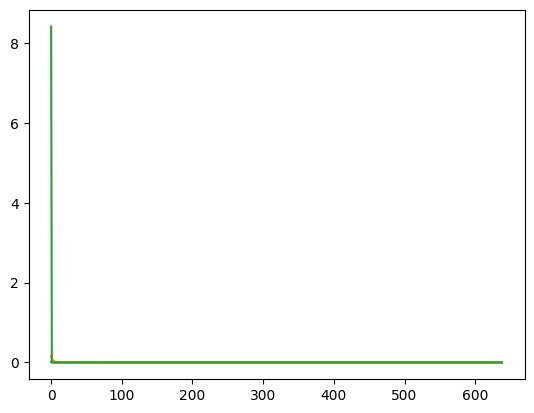

In [6]:
x = torch.arange(0.1, 64, 0.1)
print(x.size())
x_enc = crypten.cryptensor(x)

print("\nInverse Square Root: (LUT faster)")
print("  Exact :", x.sqrt().reciprocal()[:print_terms])
with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sqrt().reciprocal(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt().reciprocal(), z_enc)
with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.inv_sqrt()  # Private
    print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
    print_diff(x.sqrt().reciprocal(), z_enc)

In [45]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)
def test_inv_sqrt():
    x = torch.arange(0.1, 64, 0.1)
    print(x.size())
    x_enc = crypten.cryptensor(x)

    print("\nInverse Square Root: (LUT faster)")
    print("  Exact :", x.sqrt().reciprocal()[:print_terms])
    with cfg.temp_override({"functions.sqrt_method": 'NR', "functions.inv_sqrt_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sqrt().reciprocal(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'haar', "functions.inv_sqrt_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Haar   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt().reciprocal(), z_enc)
    with cfg.temp_override({"functions.sqrt_method": 'bior', "functions.inv_sqrt_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.inv_sqrt()  # Private
        print("  Bior   :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        # print("  Diff:", (x.sqrt()-z_enc.get_plain_text()).abs().mean(), (x.sqrt()-z_enc.get_plain_text()).abs().max())
        print_diff_numb(x.sqrt().reciprocal(), z_enc)

test_inv_sqrt()

torch.Size([639])torch.Size([639])


Inverse Square Root: (LUT faster)
Inverse Square Root: (LUT faster)

  Exact :   Exact : tensor([3.1623])
tensor([3.1623])
  Approx:  Approx:  11  iterations initerations in  0.09775965699918743 0.09391219600001932sec.:  tensor([3.1279])sec.:
 tensor([3.1279])
TAE: 3.925583e+09, MAE: 6.143323e+06, MRE: 3.429008e+07, MAX: 1.508735e+09, ARGMAX: 310TAE: 3.925583e+09, MAE: 6.143323e+06, MRE: 3.429008e+07, MAX: 1.508735e+09, ARGMAX: 310

  Haar   : 1 iterations in  Haar   :  0.19050614199841221  sec.:iterations in  tensor([1.6568])0.16954172199984896
 sec.: tensor([1.6568])
TAE: 7.910250e+00, MAE: 1.237911e-02, MRE: 5.452590e-02, MAX: 3.852136e+00, ARGMAX: 638TAE: 7.910250e+00, MAE: 1.237911e-02, MRE: 5.452590e-02, MAX: 3.852136e+00, ARGMAX: 638

  Bior   :  Bior   :  11  iterations initerations in  0.28845969000030890.2839658010016137  sec.:sec.:  tensor([-32.9000])tensor([-32.9000])

TAE: 2.906726e+02, MAE: 4.548868e-01, MRE: 2.581587e+00, MAX: 2.01532

[None, None]

## Sin (checked - Bior)

Conclusion:
- Bior is always supperior
- Interesting to comment: crypten's approximation gets worse for larger elements (with a max error for x=64 of ~5)


Logarithm (LUT faster):
  Approx: 1 iterations in 0.07554001800053811 sec.: tensor([0.0935])
TAE: 5.439527e+02, MAE: 8.512562e-01, MRE: 1.677447e+00, MAX: 5.255182e+00, ARGMAX: 613
  Haar  : 1 iterations in 0.02194484400024521 sec.: tensor([0.0979])
TAE: 2.004406e+01, MAE: 3.136786e-02, MRE: 3.824600e-01, MAX: 9.869776e-02, ARGMAX: 376
  Bior  : 1 iterations in 0.02509607800129743 sec.: tensor([0.0998])
TAE: 6.904832e-01, MAE: 1.080568e-03, MRE: 5.522512e-03, MAX: 3.189981e-03, ARGMAX: 590


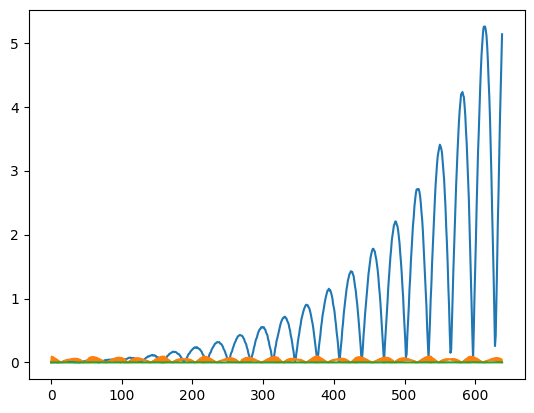

In [6]:
x = torch.arange(0.1, 64, 0.1)
x_enc = crypten.cryptensor(x)
print("\nLogarithm (LUT faster):")
# print("  x :", x) if rank == 0 else None
# print("  Exact :", x.sin()) if rank == 0 else None
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    # crypten.print("Out NR tensor: ", z_enc.get_plain_text())
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sin(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sin(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sin()  # Private
    # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sin(), z_enc)

In [7]:
import crypten.mpc as mpc
# x = torch.arange(0, 64, 0.001)
# x = torch.rand((2, 2))
# x = torch.arange(1, 10, 1)
# print(x.size())
# x_enc = crypten.cryptensor(x)
# print("Ref tensor: ", x.sin())

@mpc.run_multiprocess(world_size=2)
def test_sin():
    rank = 0
    x = torch.arange(0.1, 64, 0.1)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    # print("  x :", x) if rank == 0 else None
    # print("  Exact :", x.sin()) if rank == 0 else None
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text())
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sin(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sin(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sin()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sin(), z_enc)

test_sin()


Logarithm (LUT faster):
Logarithm (LUT faster):

  Approx:  Approx:  1 1 iterations in iterations in0.09553178199894319  0.09801385799983109sec.:  sec.: tensor([0.0936])
tensor([0.0936])
TAE: 5.427418e+02, MAE: 8.493612e-01, MRE: 1.600904e+00, MAX: 5.265533e+00, ARGMAX: 614TAE: 5.427418e+02, MAE: 8.493612e-01, MRE: 1.600904e+00, MAX: 5.265533e+00, ARGMAX: 614

  Haar  :  Haar  :  11  iterations initerations in 0.047145235001153196  0.04722025699993537sec.:  sec.: tensor([0.2899])tensor([0.2899])

TAE: 4.566585e+01, MAE: 7.146455e-02, MRE: 5.710508e-01, MAX: 2.721540e-01, ARGMAX: 439TAE: 4.566585e+01, MAE: 7.146455e-02, MRE: 5.710508e-01, MAX: 2.721540e-01, ARGMAX: 439

  Bior  :  Bior  :  11  iterations in iterations in0.051000741001189454  sec.: 0.04782099500152981 tensor([0.0999])
sec.: tensor([0.0999])
TAE: 2.934211e+00, MAE: 4.591879e-03, MRE: 1.167521e-02, MAX: 3.312176e-02, ARGMAX: 392TAE: 2.934211e+00, MAE: 4.591879e-03, MRE: 1.167521e-02, MAX: 3.312176e-02, ARGMAX: 392



[None, None]

## Cos (checked - Bior)

Conclusion:
- Same as Sin


Cos:
  Exact : tensor([0.9950])
  Approx: 1 iterations in 0.0783404600006179 sec.: tensor([0.9960])
TAE: 5.675708e+02, MAE: 8.882172e-01, MRE: 1.524325e+00, MAX: 5.876511e+00, ARGMAX: 630
  Haar  : 1 iterations in 0.020616478999727406 sec.: tensor([0.9936])
TAE: 1.992508e+01, MAE: 3.118166e-02, MRE: 2.657432e-01, MAX: 9.730029e-02, ARGMAX: 268
  Bior  : 1 iterations in 0.02372942699912528 sec.: tensor([0.9926])
TAE: 7.072368e-01, MAE: 1.106787e-03, MRE: 4.308673e-03, MAX: 3.452718e-03, ARGMAX: 537


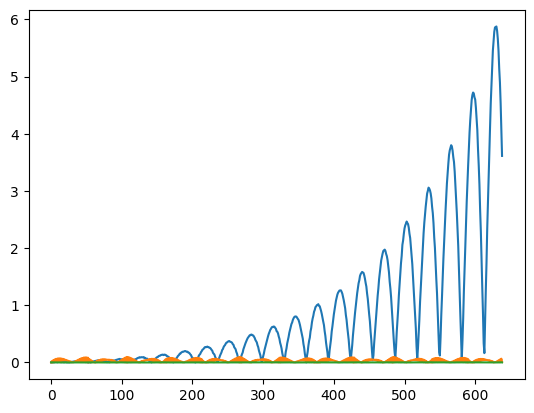

In [8]:
print("\nCos:")
print("  Exact :", x.cos()[:print_terms])
with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)
with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.cos()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.cos(), z_enc)

In [9]:
import crypten.mpc as mpc

@mpc.run_multiprocess(world_size=2)
def test_cos():
    rank = 0
    x = torch.arange(0.1, 64, 0.1)
    x_enc = crypten.cryptensor(x)
    print("\nLogarithm (LUT faster):")
    # print("  x :", x) if rank == 0 else None
    # print("  Exact :", x.cos()) if rank == 0 else None
    with cfg.temp_override({"functions.trigonometry_method": 'NR'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        # crypten.print("Out NR tensor: ", z_enc.get_plain_text())
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.cos(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        # crypten.print("Out haar tensor: ", z_enc.get_plain_text())
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.cos(), z_enc)
    with cfg.temp_override({"functions.trigonometry_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.cos()  # Private
        # crypten.print("Out bior tensor: ", z_enc.get_plain_text())
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.cos(), z_enc)

test_cos()


Logarithm (LUT faster):
Logarithm (LUT faster):

  Approx:  Approx:  11  iterations initerations in  0.101629131000663620.10571506700034661  sec.:sec.:  tensor([0.9952])
tensor([0.9952])
TAE: 5.658712e+02, MAE: 8.855574e-01, MRE: 1.458500e+00, MAX: 5.907429e+00, ARGMAX: 629TAE: 5.658712e+02, MAE: 8.855574e-01, MRE: 1.458500e+00, MAX: 5.907429e+00, ARGMAX: 629

  Haar  :  Haar  :  11  iterations in iterations in0.046007183998881374  sec.:0.05139114899975539 tensor([0.9554]) 
sec.: tensor([0.9554])
TAE: 4.230418e+01, MAE: 6.620373e-02, MRE: 4.248817e-01, MAX: 2.669937e-01, ARGMAX: 390
TAE: 4.230418e+01, MAE: 6.620373e-02, MRE: 4.248817e-01, MAX: 2.669937e-01, ARGMAX: 390
  Bior  :  Bior  :  11 iterations in  0.052484109000943135iterations in sec.:  0.050033966999762924 tensor([1.0120])
sec.: tensor([1.0120])
TAE: 2.895035e+00, MAE: 4.530571e-03, MRE: 9.009677e-03, MAX: 3.513134e-02, ARGMAX: 121TAE: 2.895035e+00, MAE: 4.530571e-03, MRE: 9.009677e-03, MAX: 3.513134e-02, ARGMAX: 121



[None, None]

## Sigmoid (checked - Bior)

Conclusion:
- Bior is superior to Haar
- For 1 party it is superior to crypten
- For 2 parties wins against crypten only sometimes (the haar always loose)


Sigmoid:
  Exact : tensor([1.6038e-28])
  Approx: 1 iterations in 0.06877207900106441 sec.: tensor([1.5259e-05])
TAE: 9.223650e-02, MAE: 7.205976e-05, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.03346517899990431 sec.: tensor([0.])
TAE: 6.407821e-01, MAE: 5.006110e-04, MRE: 1.344967e+00, MAX: 3.115845e-02, ARGMAX: 640
  Bior  : 1 iterations in 0.037396671999886166 sec.: tensor([0.])
TAE: 1.213635e-02, MAE: 9.481520e-06, MRE: 1.341115e+00, MAX: 4.950166e-04, ARGMAX: 655


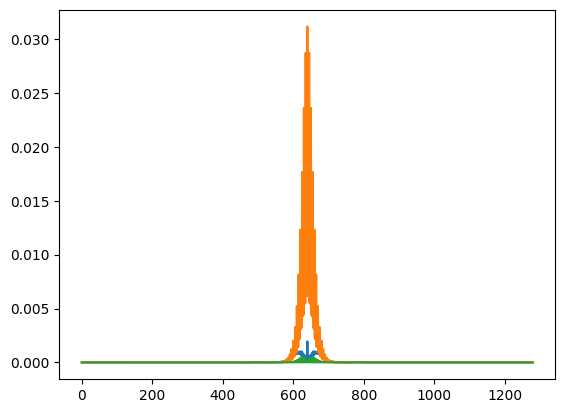

In [6]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("\nSigmoid:")
print("  Exact :", x.sigmoid()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.sigmoid()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.sigmoid(), z_enc)

In [37]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_sig():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("\nSigmoid:")
    print("  Exact :", x.sigmoid()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.sigmoid()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.sigmoid(), z_enc) 

test_sig()


Sigmoid:
Sigmoid:

  Exact :  Exact :  tensor([1.6038e-28])tensor([1.6038e-28])

  Approx:  Approx:  11  iterations initerations in  0.0813956390011299 0.07329636200120149 sec.:sec.:  tensor([1.5259e-05])
tensor([1.5259e-05])
TAE: 8.133316e-02, MAE: 6.354153e-05, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640TAE: 8.133316e-02, MAE: 6.354153e-05, MRE: 7.810717e+20, MAX: 1.953125e-03, ARGMAX: 640

  Haar  :  Haar  :  1 1 iterations initerations in  0.205692360999819360.2098632990000624  sec.: sec.: tensor([0.])tensor([0.])

TAE: 2.156555e+00, MAE: 1.684808e-03, MRE: 2.946340e+03, MAX: 4.688414e-01, ARGMAX: 481TAE: 2.156555e+00, MAE: 1.684808e-03, MRE: 2.946340e+03, MAX: 4.688414e-01, ARGMAX: 481

  Bior  :  Bior  : 1  1iterations in  0.4118447599994397iterations in sec.:  0.40863940400049614tensor([0.]) 
sec.: tensor([0.])
TAE: 6.247739e-02, MAE: 4.881046e-05, MRE: 4.354246e-01, MAX: 4.753366e-03, ARGMAX: 627TAE: 6.247739e-02, MAE: 4.881046e-05, MRE: 4.354246e-01, MAX: 4.753366e-03, 

[None, None]

## Tanh (checked - Bior)

Conclusion:
- Bior is superior to Haar
- For 1 party it is superior to crypten
- For 2 parties, bior most of the times wins against crypten

Tanh:
  Exact : tensor([-1.])
  Approx: 1 iterations in 0.05457012300030328 sec.: tensor([-1.0000])
TAE: 1.099896e-01, MAE: 8.592936e-05, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640
  Haar  : 1 iterations in 0.030402272999708657 sec.: tensor([-1.])
TAE: 6.404938e-01, MAE: 5.003858e-04, MRE: 1.370699e+10, MAX: 6.233215e-02, ARGMAX: 640
  Bior  : 1 iterations in 0.03276806500070961 sec.: tensor([-1.])
TAE: 1.109654e-02, MAE: 8.669175e-06, MRE: 6.710886e+06, MAX: 9.718239e-04, ARGMAX: 635


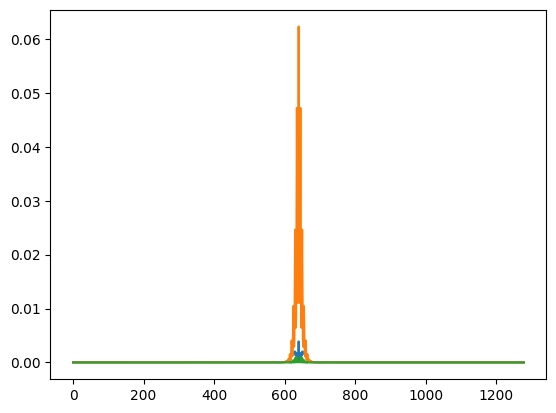

In [48]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("Tanh:")
print("  Exact :", x.tanh()[:print_terms])
with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)
with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.tanh()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.tanh(), z_enc)

In [47]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_tanh():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("Tanh:")
    print("  Exact :", x.tanh()[:print_terms])
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'reciprocal', "functions.reciprocal_method": 'NR', "functions.exp_method": 'limit'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)
    with cfg.temp_override({"functions.sigmoid_tanh_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.tanh()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.tanh(), z_enc)

test_tanh()

Tanh:Tanh:

  Exact :  Exact :  tensor([-1.])tensor([-1.])

  Approx:  Approx:  11  iterations initerations in0.0666413350008952  sec.: 0.06686643700049899  sec.:tensor([-1.0000]) 
tensor([-1.0000])
TAE: 1.052048e-01, MAE: 8.219127e-05, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640TAE: 1.052048e-01, MAE: 8.219127e-05, MRE: 8.589935e+08, MAX: 3.906250e-03, ARGMAX: 640

  Haar  :  Haar  :  11  iterations initerations in  0.283151129000543730.28329592200134357  sec.:sec.:  tensor([-1.])tensor([-1.])

TAE: 1.222870e+00, MAE: 9.553673e-04, MRE: 1.370699e+10, MAX: 1.198049e-01, ARGMAX: 643TAE: 1.222870e+00, MAE: 9.553673e-04, MRE: 1.370699e+10, MAX: 1.198049e-01, ARGMAX: 643

  Bior  :  Bior  :  11  iterations in iterations in0.15611975399951916  0.1567616629999975sec.:  sec.:tensor([-1.]) 
tensor([-1.])
TAE: 4.914162e-02, MAE: 3.839189e-05, MRE: 6.710886e+06, MAX: 9.104371e-03, ARGMAX: 636TAE: 4.914162e-02, MAE: 3.839189e-05, MRE: 6.710886e+06, MAX: 9.104371e-03, ARGMAX: 636



[None, None]

## Erf (checked - Bior)

Checked

Erf:
  Exact : tensor([-1.])
  Approx: 1 iterations in 0.09889762999955565 sec.: tensor([98524.9453])
TAE: 1.036244e+11, MRE: 8.095657e+07, MAX: 2.921903e+08, ARGMAX: 18
  Haar  : 1 iterations in 0.09378300000025774 sec.: tensor([-1.])
TAE: 2.057946e-02, MRE: 4.282105e+08, MAX: 2.197266e-03, ARGMAX: 640
  Bior  : 1 iterations in 0.045994402000360424 sec.: tensor([-1.])
TAE: 1.187288e-02, MRE: 5.947368e+06, MAX: 1.167595e-03, ARGMAX: 635


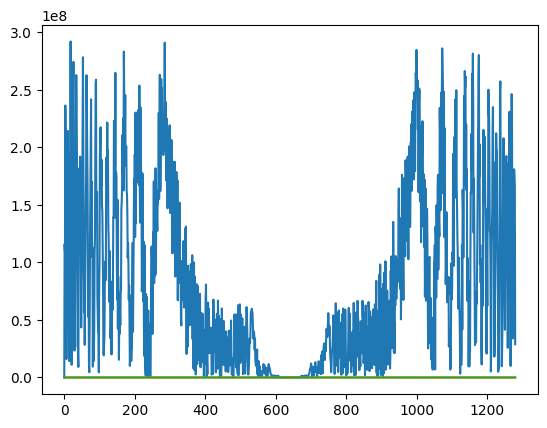

In [6]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

print("Erf:")
print("  Exact :", x.erf()[:print_terms])
with cfg.temp_override({"functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)
with cfg.temp_override({"functions.erf_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)
with cfg.temp_override({"functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.erf()  # Private
    print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
    print_diff(x.erf(), z_enc)

In [4]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=1)    
def test_erf():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    print("Erf:")
    print("  Exact :", x.erf()[:print_terms])
    with cfg.temp_override({"functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Approx:", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)
    with cfg.temp_override({"functions.erf_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Haar  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)
    with cfg.temp_override({"functions.erf_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.erf()  # Private
        print("  Bior  :", num_iters, "iterations in",  timeit.default_timer() - start1, "sec.:", z_enc.get_plain_text()[:print_terms])
        print_diff_numb(x.erf(), z_enc)

test_erf()

Erf:
  Exact : tensor([-1.])
  Approx: 1 iterations in 0.12315228500119701 sec.: tensor([98524.9453])
TAE: 1.036244e+11, MAE: 8.095657e+07, MRE: 8.095657e+07, MAX: 2.921903e+08, ARGMAX: 18
  Haar  : 1 iterations in 0.04241627800001879 sec.: tensor([-1.])
TAE: 6.389345e-01, MAE: 4.991676e-04, MRE: 1.370868e+10, MAX: 7.034302e-02, ARGMAX: 640
  Bior  : 1 iterations in 0.033058171000448056 sec.: tensor([-1.])
TAE: 1.187288e-02, MAE: 9.275687e-06, MRE: 5.947368e+06, MAX: 1.167595e-03, ARGMAX: 635


[None]

## Gelu (checked - expression with Bior)

Conclusion:
- gelu with the erf expression gives better accuracy always


Gelu:
  Exact : tensor([-0.0000, -0.0000, -0.0000,  ..., 63.7000, 63.8000, 63.9000])
  Approx: 1 iterations in 0.10031160400103545 sec.
TAE: 4.785460e+11, MAE: 3.738641e+08, MRE: 6.085073e+10, MAX: 1.071492e+09, ARGMAX: 14
  Erf: 1 iterations in 0.03810133300066809 sec.
TAE: 1.486075e-02, MAE: 1.160996e-05, MRE: 8.844507e-01, MAX: 5.359203e-04, ARGMAX: 624
  Haar: 1 iterations in 0.037558285001068725 sec.
TAE: 6.051974e-02, MAE: 4.728104e-05, MRE: 6.216888e+09, MAX: 7.675171e-03, ARGMAX: 640
  Bior: 1 iterations in 0.0404525210014981 sec.
TAE: 3.727015e-02, MAE: 2.911731e-05, MRE: 1.606750e+09, MAX: 3.186673e-03, ARGMAX: 635


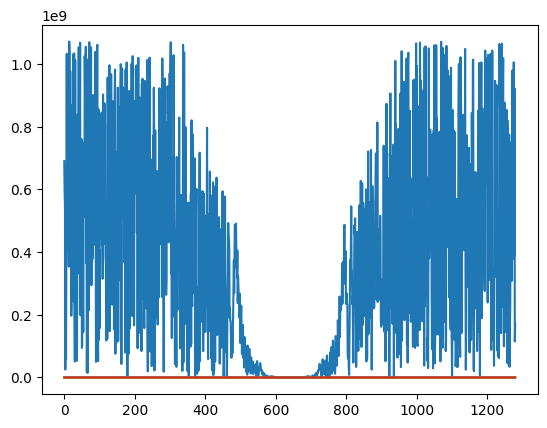

In [7]:
# x = torch.arange(start=1.01, end=10, step=0.01)
# x_enc = crypten.cryptensor(x)

x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
relu = x * (x > 0)

print("\nGelu:")
print("  Exact :", gelu)
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Erf", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)
with cfg.temp_override({"functions.gelu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.gelu()  # Private
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(gelu, z_enc)

In [7]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=2)    
def test_gelu():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    gelu = x * (1 + (x / torch.sqrt(torch.tensor(2))).erf()) / 2
    relu = x * (x > 0)

    print("\nGelu:")
    print("  Exact :", gelu)
    with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'Taylor'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)
    with cfg.temp_override({"functions.gelu_method": 'erf', "functions.erf_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Erf", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)
    with cfg.temp_override({"functions.gelu_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)
    with cfg.temp_override({"functions.gelu_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.gelu()  # Private
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(gelu, z_enc)

test_gelu()


Gelu:
Gelu:

  Exact :  Exact :  tensor([-0.0000, -0.0000, -0.0000,  ..., 63.7000, 63.8000, 63.9000])tensor([-0.0000, -0.0000, -0.0000,  ..., 63.7000, 63.8000, 63.9000])

  Approx: 1 iterations in 0.17030717299894604 sec.  Approx: 1 iterations in 0.17002814799889165 sec.

TAE: 7.092845e+11, MAE: 5.541285e+08, MRE: 9.797323e+10, MAX: 2.102173e+09, ARGMAX: 922TAE: 7.092845e+11, MAE: 5.541285e+08, MRE: 9.797323e+10, MAX: 2.102173e+09, ARGMAX: 922

  Erf: 1 iterations in 0.490305797999099 sec.  Erf: 1 iterations in 0.4926420360006887 sec.

TAE: 7.749882e-02, MAE: 6.054596e-05, MRE: 2.252943e-02, MAX: 7.545829e-03, ARGMAX: 656TAE: 7.749882e-02, MAE: 6.054596e-05, MRE: 2.252943e-02, MAX: 7.545829e-03, ARGMAX: 656

  Haar: 1 iterations in 0.0781733929998154 sec.  Haar: 1 iterations in 0.07805070400172553 sec.

TAE: 1.027960e+00, MAE: 8.030938e-04, MRE: 4.392608e+10, MAX: 8.486657e-02, ARGMAX: 641TAE: 1.027960e+00, MAE: 8.030938e-04, MRE: 4.392608e+10, MAX: 8.486657e-02, ARGMAX: 641

  Bior: 

[None, None]

## Silu (checked - expression with Bior)

Conclusion:
- silu with the sigmoid expression gives better accuracy always (by one order of magnitude)
- but the bior is also good.


Silu:
  Approx: 1 iterations in 0.6332753750029951 sec.
TAE: 3.590142e-01, MRE: 5.488147e+23, MAX: 7.207108e-01
  Sigmoid: 1 iterations in 0.16468466699006967 sec.
TAE: 3.710410e-05, MRE: 1.351435e+00, MAX: 8.265972e-04
  Haar: 1 iterations in 1.751425124995876 sec.
TAE: 3.693916e-05, MRE: 4.545507e+07, MAX: 3.875732e-03
  Bior: 1 iterations in 0.15150779200484976 sec.
TAE: 2.601743e-05, MRE: 1.431656e+07, MAX: 2.574161e-03


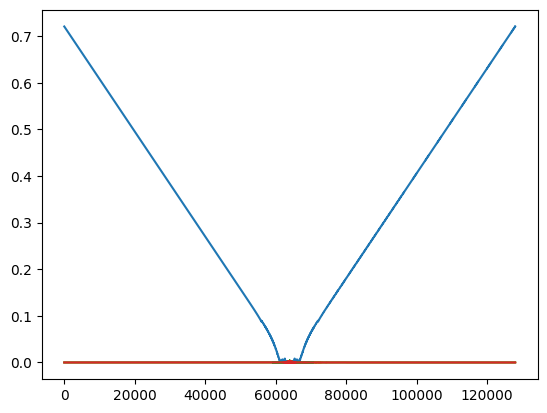

In [17]:
x = torch.arange(-64, 64, 0.1)
x_enc = crypten.cryptensor(x)

silu = x * x.sigmoid()
relu = x * (x > 0)

print("\nSilu:")
# print("  Exact :", silu)
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Approx", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Sigmoid", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'haar'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Private
    print_app("Haar", timeit.default_timer(), start1)
    print_diff(silu, z_enc)
with cfg.temp_override({"functions.silu_method": 'bior'}):
    start1 = timeit.default_timer()
    for _ in range(num_iters):
        z_enc = x_enc.silu()  # Privat6
    print_app("Bior", timeit.default_timer(), start1)
    print_diff(silu, z_enc)

In [3]:
import crypten.mpc as mpc


@mpc.run_multiprocess(world_size=1)    
def test_silu():
    x = torch.arange(-64, 64, 0.1)
    x_enc = crypten.cryptensor(x)

    silu = x * x.sigmoid()
    relu = x * (x > 0)

    print("\nSilu:")
    # print("  Exact :", silu)
    with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_tanh_method": 'reciprocal'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Approx", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)
    with cfg.temp_override({"functions.silu_method": 'sigmoid', "functions.sigmoid_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Sigmoid", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)
    with cfg.temp_override({"functions.silu_method": 'haar'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Private
        print_app("Haar", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)
    with cfg.temp_override({"functions.silu_method": 'bior'}):
        start1 = timeit.default_timer()
        for _ in range(num_iters):
            z_enc = x_enc.silu()  # Privat6
        print_app("Bior", timeit.default_timer(), start1)
        print_diff_numb(silu, z_enc)

test_silu()


Silu:
  Approx: 1 iterations in 0.08707807500104536 sec.
TAE: 4.596109e+02, MAE: 3.590710e-01, MRE: 5.764264e+23, MAX: 7.207031e-01, ARGMAX: 0
  Sigmoid: 1 iterations in 0.04870248299994273 sec.
TAE: 4.637971e-02, MAE: 3.623415e-05, MRE: 1.306379e+00, MAX: 8.265972e-04, ARGMAX: 660
  Haar: 1 iterations in 0.04018073000042932 sec.
TAE: 2.656581e+00, MAE: 2.075454e-03, MRE: 7.500757e+10, MAX: 1.705475e-01, ARGMAX: 640
  Bior: 1 iterations in 0.03634820499974012 sec.
TAE: 6.188877e-01, MAE: 4.835060e-04, MRE: 8.106751e+09, MAX: 3.224568e-02, ARGMAX: 635


[None]

#### Advanced mathematics
We are also able to compute more advanced mathematical functions on ```CrypTensors``` using iterative approximations. CrypTen provides MPC support for functions like reciprocal, exponential, logarithm, square root, tanh, etc. Notice that these are subject to numerical error due to the approximations used. 

Additionally, note that some of these functions will fail silently when input values are outside of the range of convergence for the approximations used. These do not produce errors because value are encrypted and cannot be checked without decryption. Exercise caution when using these functions. (It is good practice here to normalize input values for certain models.)